# <center><b>DIGITAL IMAGE PROCESSING (CS5102) PROJECT</b></center>
# <center><b> ✊✌HAND GESTURE RECOGNITION USING CONVOLUTIONAL NEURAL NETWORKS ☝🤙</b></center>
***
## <center><u>Done By</u>:- K SAI DINESH (CS20B1122)  ;  LOKESH REDDY (CS20B1128)</center>
***

### Import Necessary Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

from tqdm.notebook import tqdm
%matplotlib inline

### Get the train and test directory paths

In [2]:
train_dir = "./hand gesture/train/train"
test_dir = "./hand gesture/test/test"
class_labels = os.listdir(train_dir)

### Transformation & Normalization of the training images to bring about variability in the training set

In [3]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # Rotate +/- 10 degrees about x-axis.
        transforms.RandomHorizontalFlip(),  # Reverse half of the images.
        transforms.Resize(40),              # Resize the shortest side.
        transforms.CenterCrop(40),          # Crop the longest side.
        transforms.ToTensor(),              # Convert to a Tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # We have 3 channels, the first set represents the mean of the 3 channels and the second set represents the standard deviation of the 3 channels. Then, it normalizes the data values using the formula (x-mean)/std.
])

### Create the train and test datasets

In [4]:
trainset = ImageFolder(train_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)

In [5]:
print(len(trainset),len(testset))

18000 6000


### Set the seed value for getting similar results for train-validation split

In [6]:
torch.manual_seed(10)
validation_size = len(trainset)//5
train_size = len(trainset) - validation_size
train_ds, validation_ds = random_split(trainset, [train_size, validation_size])
test_ds = testset
print(f"Training set size : {len(train_ds)}")
print(f"Validation set size : {len(validation_ds)}")  
print(f"Testing set size : {len(test_ds)}")

Training set size : 14400
Validation set size : 3600
Testing set size : 6000


### Create dataloaders for each of training, validation and testing using batches of sizes 64

In [7]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(validation_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


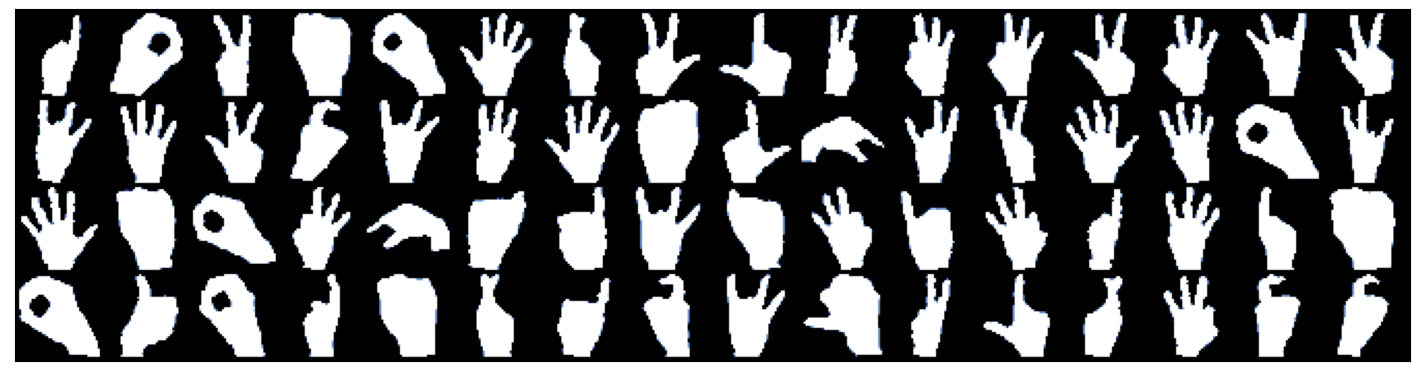

In [29]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

### Check for GPU availability

In [9]:
torch.cuda.is_available()

False

### Get the default device

In [10]:
# Pick a GPU if available else use CPU.
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

### Load the tensors to the device

In [11]:
# Move the tensors to chosen device.
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

### Initialize the dataloader object for the device

In [12]:
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    # Return a data batch after moving it to device.
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    # No. of batches.
    def __len__(self):
        return len(self.dl)

In [13]:
device = get_device()
device

device(type='cpu')

In [14]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*40*40
output_size = 3

### Creating the 2D Convolution Model

In [16]:
def accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

class BaseImageClassifier(nn.Module):

    # Generate the train predictions and calculate the loss.
    def training_process(self, batch):
        images, labels = batch 
        out = self(images)                   
        loss = F.cross_entropy(out, labels)  
        return loss
    
    # Generate the train predictions, loss and calculate the accuracy.
    def validation_process(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    # Get the combined accuracies and losses for each batch and epoch.
    def validation_summary(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # Summarize
    def end_epoch_result(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Create the CNN Model.

In [17]:
class CnnModel(BaseImageClassifier):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(6250, 256),  
            nn.ReLU(),            
            nn.Linear(256, 128),  
            nn.ReLU(),            
            nn.Linear(128, 64),           
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(class_labels)))
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [19]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 40, 40])
out.shape: torch.Size([64, 20])
out[0]: tensor([ 0.0964, -0.0721,  0.0112, -0.0561, -0.0238, -0.0298, -0.0502,  0.0340,
         0.0886, -0.0005, -0.0100, -0.1640, -0.0754,  0.0330, -0.1503,  0.0217,
        -0.0735, -0.1307, -0.1337,  0.0761], grad_fn=<SelectBackward0>)


### Create Dataloaders for each of the datasets

In [20]:
train_dl = DeviceDataLoader(train_loader, device)
validation_dl = DeviceDataLoader(validation_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [21]:
@torch.no_grad()

def evaluate_model(model, validation_loader):
    model.eval()
    outputs = [model.validation_process(batch) for batch in validation_loader]
    return model.validation_summary(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_process(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate_model(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.end_epoch_result(epoch, result)
        history.append(result)
    return history

In [22]:
model = to_device(CnnModel(), device)
history=[evaluate_model(model, validation_loader)]
history

[{'val_loss': 3.003403663635254, 'val_acc': 0.04660560190677643}]

In [23]:
epochs = 10
optimization_func = torch.optim.Adam
learning_rate = 0.001

In [24]:
from ipywidgets import FloatProgress

history+= fit(epochs, learning_rate, model, train_dl, validation_dl, optimization_func)

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.2601, val_loss: 0.0520, val_acc: 0.9846


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0993, val_loss: 0.0181, val_acc: 0.9954


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1428, val_loss: 0.0059, val_acc: 0.9978


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0288, val_loss: 0.0099, val_acc: 0.9970


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0234, val_loss: 0.0061, val_acc: 0.9981


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0260, val_loss: 0.0010, val_acc: 0.9997


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0139, val_loss: 0.0000, val_acc: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0317, val_loss: 0.0094, val_acc: 0.9976


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0246, val_loss: 0.0292, val_acc: 0.9970


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0337, val_loss: 0.0042, val_acc: 0.9987


### Visualizing Losses and Accuracies

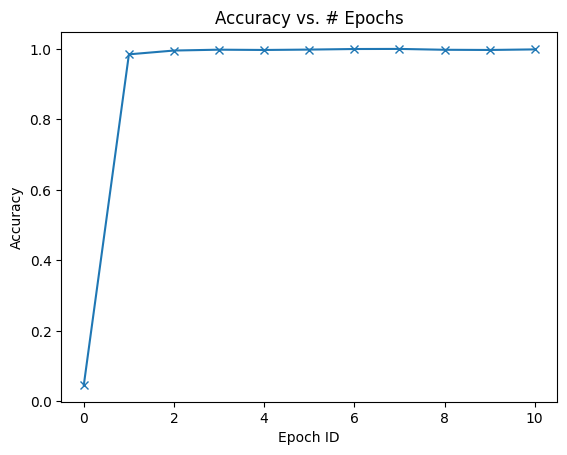

In [25]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch ID')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. # Epochs')
plt.show()

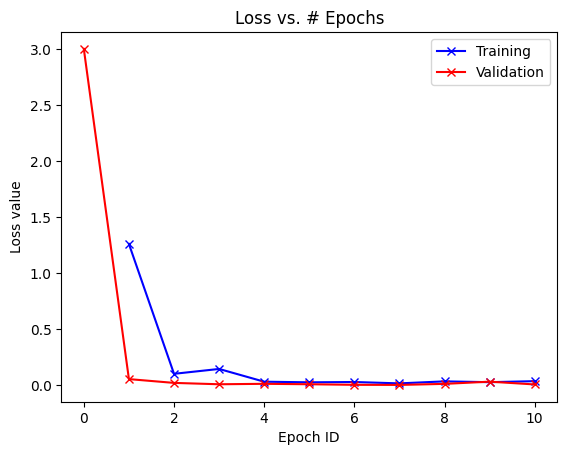

In [26]:
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('Epoch ID')
plt.ylabel('Loss value')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. # Epochs')
plt.show()

In [27]:
evaluate_model(model, test_loader)

{'val_loss': 0.03004198893904686, 'val_acc': 0.9948233962059021}

### Classifcation Report

In [28]:
pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = model(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       0.97      1.00      0.98       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      1.00      1.00       300
          11       1.00      1.00      1.00       300
          12       0.99      1.00      1.00       300
          13       1.00      0.98      0.99       300
          14       1.00      0.99      0.99       300
          15       1.00      1.00      1.00       300
          16       0.96      1.00      0.98       300
          17       0.98    

# <center> ---End of Notebook--- </center>